In [2]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import rioxarray
from tqdm.notebook import tqdm

In [3]:
# Needed to access the public bucket
os.environ["GS_NO_SIGN_REQUEST"] = "YES"

In [4]:
tqdm.pandas()

In [5]:
# Read the grid data
gdf_celdas = gpd.read_parquet("outputs/celdas_02_06_2025.parquet")

In [6]:
gdf_celdas["pop_2020"].sum()

np.float64(48359084.23803208)

In [7]:
# Read the country polygons
countries = gpd.read_parquet(
    "~/Documents/amazonia-bid/outputs/amazon_countries.parquet"
)
countries

,ADM0_EN,ADM0_PCODE,geometry
3,Bolivia (Estado Plurinacional de),BO,"MULTIPOLYGON (((-68.7719 -16.36937, -68.7717 -..."
4,Brazil,BR,"MULTIPOLYGON (((-48.54007 -27.93717, -48.54277..."
7,Colombia,CO,"MULTIPOLYGON (((-78.8898 1.50991, -78.88979 1...."
10,Ecuador,EC,"MULTIPOLYGON (((-80.20645 -3.43884, -80.20748 ..."
12,GUYANA,GY,"MULTIPOLYGON (((-58.58442 6.62612, -58.58609 6..."
19,Peru,PE,"MULTIPOLYGON (((-68.81422 -16.34799, -68.91839..."
22,Suriname,SR,"MULTIPOLYGON (((-55.28819 5.93931, -55.28819 5..."
25,Venezuela (Bolivarian Republic of),VE,"MULTIPOLYGON (((-64.93242 10.15568, -64.92978 ..."


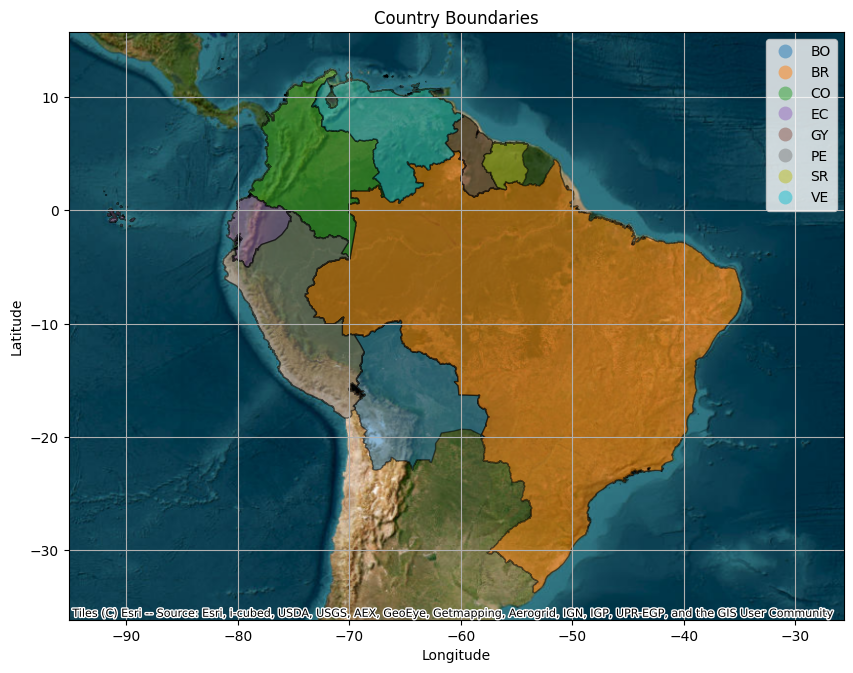

In [8]:
# Visualize the countries
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon with the population data
countries.plot(ax=ax, column="ADM0_PCODE", alpha=0.5, edgecolor="k", legend=True)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=countries.crs)

# Add the title
ax.set_title("Country Boundaries")

# Add the grid
ax.grid(True)

# Add the x and y labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [9]:
# Guyana, Suriname, Venezuela are not included in the analysis
countries_ADM0CODE = ["BR"]
amzn_countries = countries[countries["ADM0_PCODE"].isin(countries_ADM0CODE)]

In [10]:
amzn_countries = amzn_countries.sort_values(by=["ADM0_PCODE"], ascending=True)
amzn_countries

,ADM0_EN,ADM0_PCODE,geometry
4,Brazil,BR,"MULTIPOLYGON (((-48.54007 -27.93717, -48.54277..."


In [11]:
countries_labels = ["bra"]

In [12]:
amzn_countries["code"] = countries_labels

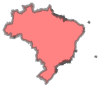

In [13]:
amzn_countries.geometry.iloc[0]

In [14]:
from pathlib import Path

In [15]:
brazil_clean_df_fn = "outputs/celdas_country_bra_02_06_2025.parquet"
if not Path(brazil_clean_df_fn).exists():
    # Filter the grid data to include only the cells that intersect with the country polygons
    gdf_celdas_bra = gdf_celdas.loc[
        gdf_celdas.intersects(amzn_countries.geometry.iloc[0])
    ]
    # Assign the country code to the filtered grid data
    gdf_celdas_bra.loc[:, "code"] = "bra"
    # Convert the cell_id to integer so it can be rasterized for population aggregation
    gdf_celdas_bra.loc[:, "cell_id"] = gdf_celdas_bra["cell_id"].astype("int32")
    # check the type
    assert gdf_celdas_bra["cell_id"].dtype

    # Load other countries cells
    gdf_celdas_others = gpd.read_parquet(
        "outputs/celdas_countries_wo_br_02_06_2025.parquet"
    )

    # Remove cells from gdf_celdas_bra that have cell_id in gdf_celdas_others
    gdf_celdas_bra_clean = gdf_celdas_bra[
        ~gdf_celdas_bra["cell_id"].isin(
            gdf_celdas_others[~gdf_celdas_others["code"].isnull()]["cell_id"].values
        )
    ]

    # Save brazil cells
    gdf_celdas_bra_clean.to_parquet(brazil_clean_df_fn, index=False)
else:
    # Load the Brazil cells
    gdf_celdas_bra_clean = gpd.read_parquet(brazil_clean_df_fn)

In [16]:
# Set the base path for the data
# BASE_PATH = "https://storage.cloud.google.com/worldpop-cog/"
BASE_PATH = "gs://worldpop-cog"
age_groups = [5, 10, 15]  # 5-9, 10-14, 15-19
genders = ["m", "f"]

In [17]:
filename = (
    f"{BASE_PATH}/{countries_labels[0]}_{genders[1]}_{age_groups[0]}_2020_cog.tif"
)
filename

'gs://worldpop-cog/bra_f_5_2020_cog.tif'

In [18]:
# Accumulate the population data for each country
countries_geodata = {}

In [19]:
filename

'gs://worldpop-cog/bra_f_5_2020_cog.tif'

In [20]:
# Read the COG file
xds = rioxarray.open_rasterio(filename, masked=True, chunks={"x": 1024, "y": 1024})

In [21]:
xds

<xarray.DataArray (band: 1, y: 46814, x: 54172)> Size: 10GB
dask.array<open_rasterio-f825ae9a7ab10235557c4db2b4d04dca<this-array>, shape=(1, 46814, 54172), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 433kB -73.99 -73.99 -73.99 ... -28.85 -28.85 -28.85
  * y            (y) float64 375kB 5.264 5.263 5.263 ... -33.74 -33.75 -33.75
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
# cast the cell_id to int32
gdf_celdas_bra_clean["cell_id"] = gdf_celdas_bra_clean["cell_id"].astype("int32")
# check the type
gdf_celdas_bra_clean["cell_id"].dtype

dtype('int32')

In [23]:
brazil_subregions_polys = gpd.read_file(
    "/Users/claudio/Downloads/regions_brazil.geojson"
)
brazil_subregions_polys

,name,geometry
0,Sul,"POLYGON ((-53.07251 -33.96693, -53.16284 -33.8..."
1,Sudeste,"POLYGON ((-29.00059 -22.95946, -32.63539 -25.0..."
2,Norte,"POLYGON ((-60.69401 -13.73407, -61.01532 -13.5..."
3,Nordeste,"POLYGON ((-29.3325 2.33596, -28.72472 2.03155,..."
4,Centro-oeste,"POLYGON ((-54.35224 -24.18381, -54.36001 -24.1..."


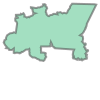

In [24]:
norte_poly = brazil_subregions_polys.loc[
    brazil_subregions_polys["name"] == "Norte", "geometry"
].iloc[0]
norte_poly

In [25]:
from shapely.geometry import box

<Axes: >

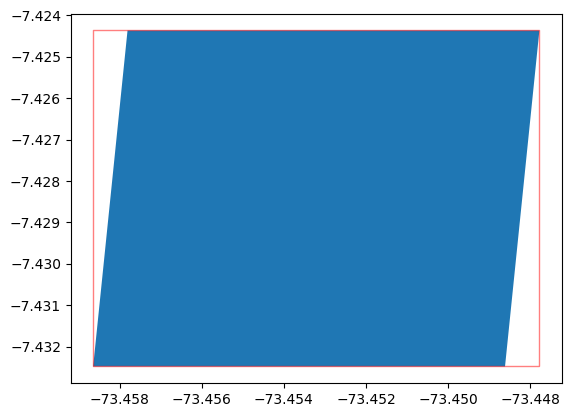

In [26]:
sample_cell = gdf_celdas_bra_clean.iloc[0].geometry
ax = gdf_celdas_bra_clean.iloc[[0]].plot()
xmin, ymin, xmax, ymax = gdf_celdas_bra_clean.iloc[[0]].total_bounds
bbox = gpd.GeoDataFrame(
    geometry=[box(xmin, ymin, xmax, ymax)],
    crs=gdf_celdas_bra_clean.crs,
)
bbox.plot(ax=ax, facecolor="none", edgecolor="red", alpha=0.5)

In [27]:
# select the first band
xds_band = xds.isel(band=0)

In [28]:
# Filter the xds arround the sample cell using efficient spatial selection

sample_cell_buffer = sample_cell.buffer(0.01)
xds_clip_box = xds_band.rio.clip_box(
    minx=sample_cell_buffer.bounds[0],
    miny=sample_cell_buffer.bounds[1],
    maxx=sample_cell_buffer.bounds[2],
    maxy=sample_cell_buffer.bounds[3],
    crs=gdf_celdas_bra_clean.crs,
)

In [29]:
xds_clipped = xds_clip_box.rio.clip(
    [sample_cell],
)

Text(0.5, 1.0, 'Brazil Population Data for Sample Cell')

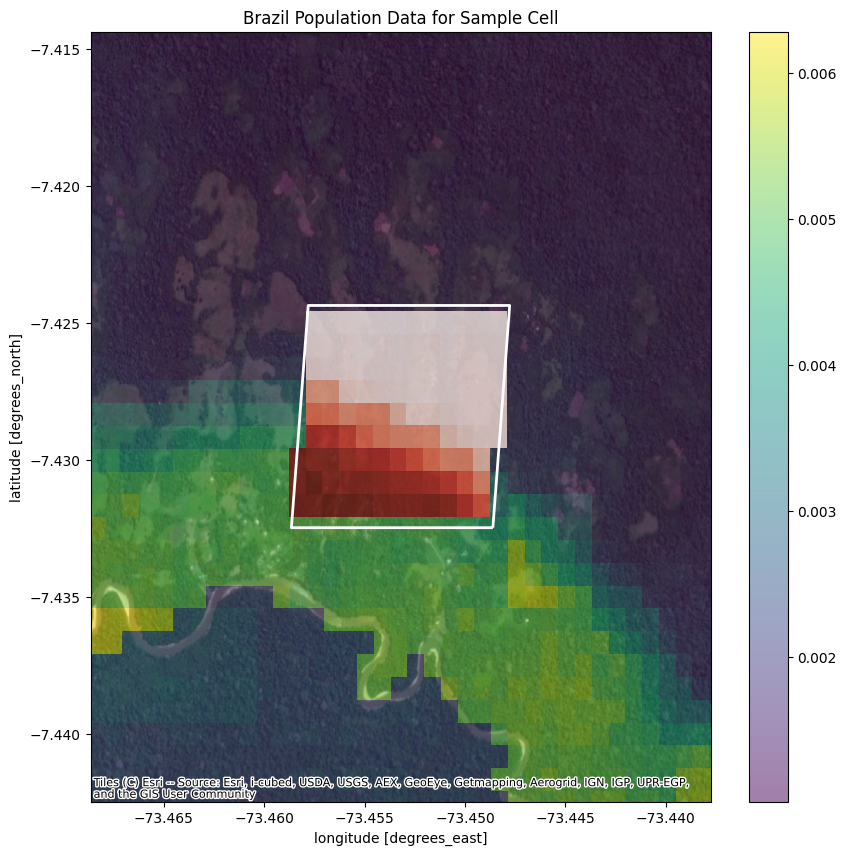

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

# plot the raster data for brazil
xds_clip_box.plot.imshow(ax=ax, cmap="viridis", alpha=0.5, add_colorbar=True)

# plot the sample cell
gdf_celdas_bra_clean.iloc[[0]].plot(
    ax=ax, facecolor="none", edgecolor="white", linewidth=2
)

# plot the subregion
xds_clipped.plot.imshow(ax=ax, cmap="Reds", alpha=0.75, add_colorbar=False)

# set the x and y limits to the sample cell buffer
ax.set_xlim(sample_cell_buffer.bounds[0], sample_cell_buffer.bounds[2])
ax.set_ylim(sample_cell_buffer.bounds[1], sample_cell_buffer.bounds[3])

# Add a basemap below all other layers
ctx.add_basemap(
    ax, source=ctx.providers.Esri.WorldImagery, crs=gdf_celdas_bra_clean.crs, zorder=-1
)

# set the title
ax.set_title("Brazil Population Data for Sample Cell")

In [31]:
from pandarallel import pandarallel

In [32]:
pandarallel.initialize(nb_workers=6, progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [33]:
x = gdf_celdas_bra_clean.iloc[100]
xds_band.rio.clip_box(
    minx=x.geometry.bounds[0],
    miny=x.geometry.bounds[1],
    maxx=x.geometry.bounds[2],
    maxy=x.geometry.bounds[3],
    crs=gdf_celdas_bra_clean.crs,
).rio.clip([x.geometry]).sum().sum().values

array(36.005554, dtype=float32)

In [34]:
Path(BASE_PATH)

PosixPath('gs:/worldpop-cog')

In [35]:
# BASE_PATH = "https://storage.cloud.google.com/worldpop-cog/"
BASE_PATH = "gs://worldpop-cog"
age_groups = [5, 10, 15]  # 5-9, 10-14, 15-19
genders = ["m", "f"]

In [36]:
filelist = [
    f"{BASE_PATH}/{countries_labels[0]}_{gender}_{age_group}_2020_cog.tif"
    for gender in genders
    for age_group in age_groups
]
filelist

['gs://worldpop-cog/bra_m_5_2020_cog.tif',
 'gs://worldpop-cog/bra_m_10_2020_cog.tif',
 'gs://worldpop-cog/bra_m_15_2020_cog.tif',
 'gs://worldpop-cog/bra_f_5_2020_cog.tif',
 'gs://worldpop-cog/bra_f_10_2020_cog.tif',
 'gs://worldpop-cog/bra_f_15_2020_cog.tif']

In [ ]:
from pathlib import Path

for file in tqdm(filelist, desc="Processing files"):
    gender = file.split("_")[-4]
    age = file.split("_")[-3]
    col_name = f"pop_2020_{gender}_{age}"
    temp_parquet = f"outputs/{col_name}_temp.parquet"
    print(f"Processing column: {col_name}")

    if col_name in gdf_celdas_bra_clean.columns:
        print(f"Column {col_name} already exists, skipping...")
        continue

    if Path(temp_parquet).exists():
        print(f"Loading {col_name} from {temp_parquet}")
        gdf_celdas_bra_clean[col_name] = gpd.read_parquet(temp_parquet)[col_name]
        continue

    xds = rioxarray.open_rasterio(file, masked=True, chunks={"x": 1024, "y": 1024})
    xds_band = xds.isel(band=0)
    gdf_celdas_bra_clean[col_name] = gdf_celdas_bra_clean.progress_apply(
        lambda x: xds_band.rio.clip_box(
            minx=x.geometry.bounds[0],
            miny=x.geometry.bounds[1],
            maxx=x.geometry.bounds[2],
            maxy=x.geometry.bounds[3],
            crs=gdf_celdas_bra_clean.crs,
        )
        .rio.clip([x.geometry])
        .sum()
        .sum()
        .values,
        axis=1,
    )
    # Save the intermediate result
    gdf_celdas_bra_clean[col_name] = gdf_celdas_bra_clean[col_name].astype(float)
    gdf_celdas_bra_clean[[col_name]].to_parquet(temp_parquet)

Processing files:   0%|          | 0/6 [00:00<?, ?it/s]

Processing column: pop_2020_m_5
Column pop_2020_m_5 already exists, skipping...
Processing column: pop_2020_m_10


  0%|          | 0/17004 [00:00<?, ?it/s]

Processing column: pop_2020_m_15


  0%|          | 0/17004 [00:00<?, ?it/s]

Processing column: pop_2020_f_5


  0%|          | 0/17004 [00:00<?, ?it/s]

Processing column: pop_2020_f_10


  0%|          | 0/17004 [00:00<?, ?it/s]

Processing column: pop_2020_f_15


  0%|          | 0/17004 [00:00<?, ?it/s]

In [ ]:
gdf_celdas_bra_clean[col_name].astype(float)

0          0.329185
1          0.560032
2         16.507923
3          3.606850
4         24.989681
            ...    
16999    268.545807
17000    133.571472
17001     51.492882
17002     15.116997
17003     17.825058
Name: pop_2020_m_5, Length: 17004, dtype: float64

In [ ]:
gdf_celdas_bra_clean[col_name] = gdf_celdas_bra_clean[col_name].astype(float)
gdf_celdas_bra_clean[[col_name]].to_parquet(temp_parquet)

In [50]:
gdf_celdas_bra_clean.columns

Index(['cell_id', 'smod', 'polygon_id', 'category', 'pop_1975', 'pop_1980',
       'pop_1985', 'pop_1990', 'pop_1995', 'pop_2000', 'pop_2005', 'pop_2010',
       'pop_2015', 'pop_2020', 'geometry', 'code', 'pop_2020_m_5',
       'pop_2020_m_10', 'pop_2020_m_15', 'pop_2020_f_5', 'pop_2020_f_10',
       'pop_2020_f_15'],
      dtype='object')

In [42]:
if False:
    gdf_celdas_bra_clean["pop_f_15"] = gdf_celdas_bra_clean["pop_f_15"].progress_apply(
        lambda x: x.values
    )

In [51]:
if False:
    gdf_celdas_bra_clean["pop_m_10"] = gdf_celdas_bra_clean["pop_m_10"].progress_apply(
        lambda x: x.values
    )

In [ ]:
gdf_celdas_bra_clean[
    [
        "pop_2020_m_5",
        "pop_2020_m_10",
        "pop_2020_m_15",
        "pop_2020_f_5",
        "pop_2020_f_10",
        "pop_2020_f_15",
    ]
]

,pop_2020_m_5,pop_2020_m_10,pop_2020_m_15,pop_2020_f_5,pop_2020_f_10,pop_2020_f_15
0,0.329185,0.279947,0.259563,0.287719,0.268754,0.239487
1,0.560032,0.476265,0.441587,0.489488,0.457222,0.407432
2,16.507923,13.899233,11.649813,16.430574,13.425953,12.238817
3,3.606850,3.036872,2.545391,3.589950,2.933464,2.674084
4,24.989681,21.040646,17.635475,24.872589,20.324192,18.527111
...,...,...,...,...,...,...
16999,268.545807,257.162964,264.637146,249.478012,273.883209,245.462540
17000,133.571472,127.909767,131.627350,124.087372,136.226227,122.090118
17001,51.492882,49.310246,50.743408,47.836681,52.516315,47.066730
17002,15.116997,14.476233,14.896971,14.043631,15.417451,13.817592


In [53]:
(gdf_celdas_bra_clean["pop_2020_f_5"] == gdf_celdas_bra_clean["pop_2020_f_10"]).all()

np.False_

In [54]:
(gdf_celdas_bra_clean["pop_2020_f_5"] == gdf_celdas_bra_clean["pop_2020_f_15"]).all()

np.False_

In [56]:
gdf_celdas_bra_clean.head()

,cell_id,smod,polygon_id,category,pop_1975,pop_1980,pop_1985,pop_1990,pop_1995,pop_2000,...,pop_2015,pop_2020,geometry,code,pop_2020_m_5,pop_2020_m_10,pop_2020_m_15,pop_2020_f_5,pop_2020_f_10,pop_2020_f_15
0,10990,rural,01462-1-1,non_urban_area,33.774789,39.909487,49.279085,59.290326,73.589393,119.270242,...,201.887324,232.318658,"POLYGON ((-73.44861 -7.43248, -73.44778 -7.424...",bra,0.329185,0.279947,0.259563,0.287719,0.268754,0.239487
1,11340,rural,08474-1-1,non_urban_area,40.787618,45.215853,57.612562,69.692169,101.768666,139.175720,...,246.491946,290.713642,"POLYGON ((-73.21709 -7.42437, -73.21626 -7.416...",bra,0.560032,0.476265,0.441587,0.489488,0.457222,0.407432
2,11420,rural,06882-1-1,non_urban_area,66.769884,70.425864,80.678272,91.001020,104.945799,124.330922,...,214.019614,243.234062,"POLYGON ((-72.97373 -5.73784, -72.97309 -5.729...",bra,16.507923,13.899233,11.649813,16.430574,13.425953,12.238817
3,11429,rural,06882-1-1,non_urban_area,57.325188,62.179693,71.923945,81.314624,93.044423,109.422163,...,185.257106,195.221200,"POLYGON ((-72.96436 -5.74594, -72.96372 -5.737...",bra,3.606850,3.036872,2.545391,3.589950,2.933464,2.674084
4,11430,rural,08279-1-1,non_urban_area,85.743314,92.389529,106.908953,121.159632,139.175524,164.274082,...,280.558966,307.438278,"POLYGON ((-72.958 -5.66491, -72.95737 -5.65681...",bra,24.989681,21.040646,17.635475,24.872589,20.324192,18.527111


In [ ]:
gdf_celdas_bra_clean[
    [
        "pop_2020_m_5",
        "pop_2020_m_10",
        "pop_2020_m_15",
        "pop_2020_f_5",
        "pop_2020_f_10",
        "pop_2020_f_15",
    ]
].dtypes

pop_2020_m_5     float64
pop_2020_m_10    float64
pop_2020_m_15    float64
pop_2020_f_5     float64
pop_2020_f_10    float64
pop_2020_f_15    float64
dtype: object

In [ ]:
gdf_celdas_bra_clean[
    [
        "pop_2020_m_5",
        "pop_2020_m_10",
        "pop_2020_m_15",
        "pop_2020_f_5",
        "pop_2020_f_10",
        "pop_2020_f_15",
    ]
].describe()

,pop_2020_m_5,pop_2020_m_10,pop_2020_m_15,pop_2020_f_5,pop_2020_f_10,pop_2020_f_15
count,17004.000000,17004.000000,17004.000000,17004.000000,17004.000000,17004.000000
mean,66.687155,64.071338,66.179680,63.817414,62.345425,65.364134
std,114.142126,108.961873,114.233754,109.112798,107.232511,114.996273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.285299,7.989437,8.182149,7.944907,7.716123,7.852474
50%,23.082977,22.170316,22.693427,22.021669,21.406769,21.749287
75%,71.783161,68.981518,70.764952,68.513201,66.943010,68.921192
max,1451.577026,1345.323242,1420.161133,1404.607910,1353.111328,1444.431641


In [ ]:
gdf_celdas_bra_clean[
    [
        "pop_2020_m_5",
        "pop_2020_m_10",
        "pop_2020_m_15",
        "pop_2020_f_5",
        "pop_2020_f_10",
        "pop_2020_f_15",
    ]
].sum().round()

pop_2020_m_5     1133948.0
pop_2020_m_10    1089469.0
pop_2020_m_15    1125319.0
pop_2020_f_5     1085151.0
pop_2020_f_10    1060122.0
pop_2020_f_15    1111452.0
dtype: float64

In [61]:
gdf_celdas_bra_clean["pop_2020"].sum().round()

np.float64(25133801.0)

In [ ]:
gdf_celdas_bra_clean[
    [
        "pop_2020_m_5",
        "pop_2020_m_10",
        "pop_2020_m_15",
        "pop_2020_f_5",
        "pop_2020_f_10",
        "pop_2020_f_15",
    ]
].sum().sum()

np.float64(6605461.353451502)

In [ ]:
gdf_celdas_bra_with_pop_df = gdf_celdas_bra_clean[
    [
        "cell_id",
        "smod",
        "geometry",
        "code",
        "polygon_id",
        "pop_2020_m_5",
        "pop_2020_f_5",
        "pop_2020_m_10",
        "pop_2020_f_10",
        "pop_2020_m_15",
        "pop_2020_f_15",
    ]
]

In [64]:
# poblacion hombres
gdf_celdas_bra_with_pop_df["pop_m"] = (
    gdf_celdas_bra_with_pop_df["pop_2020_m_5"]
    + gdf_celdas_bra_with_pop_df["pop_2020_m_10"]
    + gdf_celdas_bra_with_pop_df["pop_2020_m_15"]
)

# poblacion mujeres
gdf_celdas_bra_with_pop_df["pop_f"] = (
    gdf_celdas_bra_with_pop_df["pop_2020_f_5"]
    + gdf_celdas_bra_with_pop_df["pop_2020_f_10"]
    + gdf_celdas_bra_with_pop_df["pop_2020_f_15"]
)
# poblacion total
gdf_celdas_bra_with_pop_df["pop_total"] = (
    gdf_celdas_bra_with_pop_df["pop_m"] + gdf_celdas_bra_with_pop_df["pop_f"]
)

# poblacion en edad de escuela primaria
gdf_celdas_bra_with_pop_df["pop_primary_school_age"] = (
    gdf_celdas_bra_with_pop_df["pop_2020_m_5"]
    + gdf_celdas_bra_with_pop_df["pop_2020_f_5"]
)

# poblacion en edad de escuela secundaria
gdf_celdas_bra_with_pop_df["pop_secondary_school_age"] = (
    gdf_celdas_bra_with_pop_df["pop_2020_m_10"]
    + gdf_celdas_bra_with_pop_df["pop_2020_f_10"]
    + gdf_celdas_bra_with_pop_df["pop_2020_m_15"]
    + gdf_celdas_bra_with_pop_df["pop_2020_f_15"]
)

/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/claudio/Documents/bid-amazonia-pop-centers/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: Setti

In [65]:
gdf_celdas_bra_with_pop_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17004 entries, 0 to 17003
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cell_id                   17004 non-null  int32   
 1   smod                      17004 non-null  object  
 2   geometry                  17004 non-null  geometry
 3   code                      17004 non-null  object  
 4   polygon_id                17004 non-null  object  
 5   pop_2020_m_5              17004 non-null  float64 
 6   pop_2020_f_5              17004 non-null  float64 
 7   pop_2020_m_10             17004 non-null  float64 
 8   pop_2020_f_10             17004 non-null  float64 
 9   pop_2020_m_15             17004 non-null  float64 
 10  pop_2020_f_15             17004 non-null  float64 
 11  pop_m                     17004 non-null  float64 
 12  pop_f                     17004 non-null  float64 
 13  pop_total                 17004 non-nu

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_2462/3708059820.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


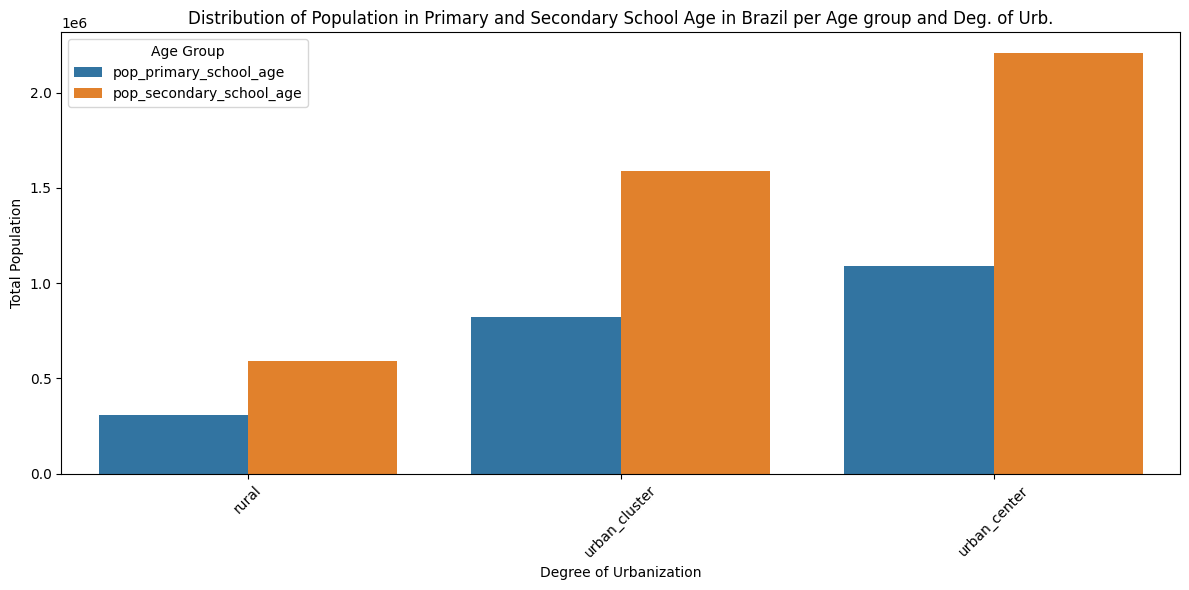

In [66]:
import seaborn as sns

import matplotlib.pyplot as plt

# Prepare the data for plotting
plot_data = gdf_celdas_bra_with_pop_df[
    ["code", "smod", "pop_primary_school_age", "pop_secondary_school_age"]
].copy()
plot_data = plot_data.melt(
    id_vars=["code", "smod"],
    value_vars=["pop_primary_school_age", "pop_secondary_school_age"],
    var_name="Age Group",
    value_name="Population",
)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data,
    x="smod",
    y="Population",
    hue="Age Group",
    ci=None,
    estimator=sum,
    dodge=True,
)

# Customize the plot
plt.title(
    "Distribution of Population in Primary and Secondary School Age in Brazil per Age group and Deg. of Urb."
)
plt.xlabel("Degree of Urbanization")
plt.ylabel("Total Population")
plt.legend(title="Age Group")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [68]:
gdf_celdas_bra_with_pop_df.to_parquet(
    "outputs/brazil_worldpop_school_age_celdas_01_07_2025.parquet", index=False
)